# Introduction

The goal of this notebook is to follow some of the analysis of the paper "The price impact of order book events" by Cont, Kukanov, and Stoikov (2012). The later sections, however, do stray away from their analysis slightly. The paper is available [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1712822). Essentially, their paper studies order flow imbalance (OFI) and price impact with empirical analysis on randomly selected US stocks, finding OFI statistically significant in a linear model of instataneous price impact (admittedly, under an idealized order book model). Instead of US stock data, we will be using order book data from Binance (available [here](https://www.binance.com/en/landing/data)) for perpetual coin-denominated futures contracts for Bitcoin, Ethereum, and Solana during the period of January 2024 - May 2024. These three were chosen for being high volume traded cryptocurrencies on an overall scale, but analysis of lower volume coins could be of interest as well. Let us define some terms from the paper before we begin.

Denote $\delta$ to be the tick size. Consider a time interval $[t_{k-1}, t_k]$, let $P^b_k$ be the bid price at time $t_k$ and $P^s_k$ be the respective ask price. Let $P_k = \frac{P_k^b + P_k^s}{2 \delta}$ be the tick-size normalized midprice and denote $\Delta P_k = P_k - P_{k-1}$ to be the midprice change. The tickers data from Binance contains the best bid and best ask price with their respective quantities at every tick. To calculate OFI, firstly consider the observations $(P_n^b, q_n^b, P_n^s, q_n^s)$ where $n$ indexes each tick. Let 
$$
e_n = q_n^b \text{ind}(P_n^b \geq P_{n-1}^b) - q_{n-1}^b \text{ind}(P_n^b \leq P_{n-1}^b) - q_n^s \text{ind}(P_n^s \leq P_{n-1}^s) + q_{n-1}^s \text{ind}(P_n^s \geq P_{n-1}^s)
$$
reprsent the signed contributions of order book events to supply/demand. 

Next, the paper considers the two uniform time grids $\{T_0, ..., T_I\}$ and $\{t_{0,0}, ..., t_{I,K}\}$ with $T_i - T_{i-1} = 30$ minutes and $t_{k,i} - t_{k-1,i} = 10$ seconds. Take $N()$ to be a function such that $N(t_{k-1,i}) + 1$ and $N(t_{k,i})$ are the index of the first and last order book event in the interval $[t_{k-1, i}, t_{k, i}]$  Then within a large interval $[T_{i-1}, T_i]$, we have
$$\Delta P_{k,i} = \frac{P_{N(t_{k,i})}^b + P_{N(t_{k,i})}^s}{2 \delta} - \frac{P_{N(t_{k-1,i})}^b + P_{N(t_{k-1,i})}^s}{2 \delta}
$$ 
and 
$$\text{OFI}_{k,i} = \sum_{n=N(t_{k-1,i})+1}^{N(t_{k,i})} e_n
$$ The paper then considers the regression model

The paper also defines an estimator for depth in their stylized model on the interval $[T_{i-1}, T_i]$ as
$$
D_i = \frac{1}{2} \left[ 
\frac{
\sum_{n=N(T_{i-1})+1}^{N(T_i)} \left( q_n^b \text{ind}\left( P_n^b < P_{n-1}^b \right) + q_{n-1}^b \text{ind}\left( P_n^b > P_{n-1}^b \right) \right)
}{
\sum_{n=N(T_{i-1})+1}^{N(T_i)} \text{ind}\left( P_n^b \neq P_{n-1}^b \right)
} + 
\frac{
\sum_{n=N(T_{i-1})+1}^{N(T_i)} \left( q_n^s \text{ind}\left( P_n^s > P_{n-1}^s \right) + q_{n-1}^s \text{ind}\left( P_n^s < P_{n-1}^s \right) \right)
}{
\sum_{n=N(T_{i-1})+1}^{N(T_i)} \text{ind}\left( P_n^s \neq P_{n-1}^s \right)
}
\right]
$$
I will not be considering the depth estimator in this notebook, but it could be of interest to consider in the future.

The model that the paper posits is 
$$
\Delta P_{k,i} = \beta_i \text{OFI}_{k,i} + \epsilon_{k,i}
$$
where one can interpret it as a linear model of the instantaneous price impact of order book events arriving within the interval $[t_{k-1}, t_k]$.
We will estimate it for the three perpectual contracts with OLS. There are some practical shortcomings with this model. But we will proceed with it for now. Later, we will consider adjustments to the model.

# Data processing
In this section, I will walk through the process I use to prepare the data for statistical modeling. The data downloaded from Binance comes as a series of csv files, each containing the order book data for a single month. Here is a sample of the data:

In [1]:
# | code-fold: true
import duckdb
import polars as pl
import glob
import os

In [2]:
pl.scan_csv("./data/ticker/BTCUSD_PERP-bookTicker-2024-01.csv").head(5).collect()

update_id,best_bid_price,best_bid_qty,best_ask_price,best_ask_qty,transaction_time,event_time
i64,f64,f64,f64,f64,i64,i64
820182436406,42305.4,2672.0,42305.5,2584.0,1704067200007,1704067200013
847746096711,42773.0,3493.0,42773.1,230.0,1706664547018,1706664547024
820182436440,42305.4,3863.0,42305.5,2584.0,1704067200010,1704067200016
847746096760,42773.0,3639.0,42773.1,230.0,1706664547020,1706664547027
820182436494,42305.4,4739.0,42305.5,2584.0,1704067200012,1704067200024


I will go through the data processing steps using BTCUSD_PERP. The same steps will be applied to ETHUSD_PERP and SOLUSD_PERP. Firstly, I will load the data into a DuckDB database since my RAM is limited. I think this might not be the most efficient format for timeseries, but it's the easiest for me to setup for ingestion. Also, I'm not a SQL expert, so the following queries probably have optimizations. During the process, I will transform the transaction_time and event_time columns into timestamps and calculate the midprices. The distinction between transaction_time and event_time is that the former is when the data got recorded and the latter is when the data is pushed out from the server (see the discussion [here](https://dev.binance.vision/t/meaning-of-event-time-transaction-time-fields/5449) or [here](https://dev.binance.vision/t/add-event-time-field-to-spot-websocket-book-streams/1390)). The difference between the two is on the order of milliseconds, so I suspect that it's negligible for our purposes as we will be aggregating on a 10s scale.

In [3]:
symbol = "BTCUSD_PERP"
tick_size = 0.1
data_dir = "./data/ticker"
files = sorted(glob.glob(f"{data_dir}/{symbol}*.csv"))
con = duckdb.connect(f"{data_dir}/{symbol}.db")
cols = f"update_id, best_bid_price, best_bid_qty, best_ask_price, best_ask_qty, \
        ROUND((best_bid_price + best_ask_price) / (2 * {tick_size}), 1) AS mid_price, \
        EPOCH_MS(event_time) AS event_time, EPOCH_MS(transaction_time) AS transaction_time, \
        'BTCUSD_PERP' AS symbol"
query = f"""\
        CREATE TABLE tick AS SELECT {cols} 
        FROM read_csv({files})
        """
con.execute(query)

Let's take a quick look at what the data looks like now.

In [4]:
con.sql("SELECT * FROM tick LIMIT 5")

┌──────────────┬────────────────┬──────────────┬───┬──────────────────────┬──────────────────────┬─────────────┐
│  update_id   │ best_bid_price │ best_bid_qty │ … │      event_time      │   transaction_time   │   symbol    │
│    int64     │     double     │    double    │   │      timestamp       │      timestamp       │   varchar   │
├──────────────┼────────────────┼──────────────┼───┼──────────────────────┼──────────────────────┼─────────────┤
│ 820182436406 │        42305.4 │       2672.0 │ … │ 2024-01-01 00:00:0…  │ 2024-01-01 00:00:0…  │ BTCUSD_PERP │
│ 847746096711 │        42773.0 │       3493.0 │ … │ 2024-01-31 01:29:0…  │ 2024-01-31 01:29:0…  │ BTCUSD_PERP │
│ 820182436440 │        42305.4 │       3863.0 │ … │ 2024-01-01 00:00:0…  │ 2024-01-01 00:00:0…  │ BTCUSD_PERP │
│ 847746096760 │        42773.0 │       3639.0 │ … │ 2024-01-31 01:29:0…  │ 2024-01-31 01:29:0…  │ BTCUSD_PERP │
│ 820182436494 │        42305.4 │       4739.0 │ … │ 2024-01-01 00:00:0…  │ 2024-01-01 00:00:0… 

In [5]:
con.sql("SELECT mid_price from tick LIMIT 10")

┌───────────┐
│ mid_price │
│  double   │
├───────────┤
│  423054.5 │
│  427730.5 │
│  423054.5 │
│  427730.5 │
│  423054.5 │
│  427730.5 │
│  423054.5 │
│  427730.5 │
│  423054.5 │
│  427730.5 │
├───────────┤
│  10 rows  │
└───────────┘

In [6]:
con.sql("SELECT count(update_id) FROM tick")

┌──────────────────┐
│ count(update_id) │
│      int64       │
├──────────────────┤
│        821486019 │
└──────────────────┘

Now I will calculate the $e_n$ as defined above.

In [7]:
calculation = f"""\
                WITH cte AS (
                SELECT 
                        best_bid_qty AS q_b_n,
                        LAG(best_bid_qty, 1) OVER (ORDER BY transaction_time, update_id) AS q_b_n_minus_1,
                        best_ask_qty AS q_s_n,
                        LAG(best_ask_qty, 1) OVER (ORDER BY transaction_time, update_id) AS q_s_n_minus_1,
                        best_bid_price AS P_b_n,
                        LAG(best_bid_price, 1) OVER (ORDER BY transaction_time, update_id) AS P_b_n_minus_1,
                        best_ask_price AS P_s_n,
                        LAG(best_ask_price, 1) OVER (ORDER BY transaction_time, update_id) AS P_s_n_minus_1,
                        mid_price,
                        LAG (mid_price, 1) OVER (ORDER BY transaction_time, update_id) AS mid_price_lag,
                        transaction_time,
                        update_id,
                        symbol
                FROM tick
                )
                SELECT 
                (
                        q_b_n * CASE WHEN P_b_n >= P_b_n_minus_1 THEN 1 ELSE 0 END
                        - q_b_n_minus_1 * CASE WHEN P_b_n <= P_b_n_minus_1 THEN 1 ELSE 0 END
                        - q_s_n * CASE WHEN P_s_n <= P_s_n_minus_1 THEN 1 ELSE 0 END
                        + q_s_n_minus_1 * CASE WHEN P_s_n >= P_s_n_minus_1 THEN 1 ELSE 0 END
                ) AS e_n,
                mid_price - mid_price_lag AS mid_price_change,
                transaction_time,
                symbol
                FROM 
                cte
                ORDER BY transaction_time, update_id
                """
query = f"""\
        CREATE TABLE rolling AS
        {calculation}
        """
con.execute(query)

The resulting table looks like this:

In [8]:
con.sql("SELECT * FROM rolling LIMIT 5")

┌────────┬──────────────────┬─────────────────────────┬─────────────┐
│  e_n   │ mid_price_change │    transaction_time     │   symbol    │
│ double │      double      │        timestamp        │   varchar   │
├────────┼──────────────────┼─────────────────────────┼─────────────┤
│   NULL │             NULL │ 2024-01-01 00:00:00.007 │ BTCUSD_PERP │
│ 1191.0 │              0.0 │ 2024-01-01 00:00:00.01  │ BTCUSD_PERP │
│  876.0 │              0.0 │ 2024-01-01 00:00:00.012 │ BTCUSD_PERP │
│  550.0 │              0.0 │ 2024-01-01 00:00:00.014 │ BTCUSD_PERP │
│    5.0 │              0.0 │ 2024-01-01 00:00:00.015 │ BTCUSD_PERP │
└────────┴──────────────────┴─────────────────────────┴─────────────┘

Finally, let's aggregate the data into 10s intervals and calculate the OFI and midprice changes. I'll do $(t_{k-1}, t_k]$ so that the midprice change is calculated close to close.

In [9]:
query = f"""\
        CREATE TABLE agg_10s AS
        WITH min_time_tbl AS (
                SELECT date_trunc('year', MIN(transaction_time)) AS min_time
                FROM rolling
        )
        SELECT 
        (
                 min_time + INTERVAL '10 seconds' * (FLOOR(DATE_PART('epoch', transaction_time - min_time) / 10) + 1)::INT
        ) AS time_bucket_end,
        SUM(e_n) AS order_flow_imbalance,
        SUM(mid_price_change) AS mid_price_change,
        symbol,
        COUNT(*) AS num_ticks
        FROM rolling, min_time_tbl
        GROUP BY symbol, min_time + INTERVAL '10 seconds' * (FLOOR(DATE_PART('epoch', transaction_time - min_time) / 10) + 1)::INT
        ORDER BY time_bucket_end
        """
con.execute(query)

Let's take a quick look at the data to make sure everything looks good.

In [10]:
con.sql("SELECT * FROM agg_10s LIMIT 5")

┌─────────────────────┬──────────────────────┬──────────────────┬─────────────┬───────────┐
│   time_bucket_end   │ order_flow_imbalance │ mid_price_change │   symbol    │ num_ticks │
│      timestamp      │        double        │      double      │   varchar   │   int64   │
├─────────────────────┼──────────────────────┼──────────────────┼─────────────┼───────────┤
│ 2024-01-01 00:00:10 │             -56352.0 │           -171.0 │ BTCUSD_PERP │       898 │
│ 2024-01-01 00:00:20 │                777.0 │              8.0 │ BTCUSD_PERP │       692 │
│ 2024-01-01 00:00:30 │              23537.0 │            112.0 │ BTCUSD_PERP │       624 │
│ 2024-01-01 00:00:40 │              56473.0 │            133.0 │ BTCUSD_PERP │       861 │
│ 2024-01-01 00:00:50 │               1594.0 │              0.0 │ BTCUSD_PERP │       364 │
└─────────────────────┴──────────────────────┴──────────────────┴─────────────┴───────────┘

In [11]:
con.close()

Now I'll repeat the process for ETHUSD_PERP and SOLUSD_PERP.

In [12]:
# | code-fold: true
import logging


def create_db(symbol, data_dir, tick_size):
    logging.basicConfig(level=logging.INFO)
    logging.info(f"Creating database for {symbol}")
    files = sorted(glob.glob(f"{data_dir}/{symbol}*.csv"))
    with duckdb.connect(f"{data_dir}/{symbol}.db") as con:
        cols = f"update_id, best_bid_price, best_bid_qty, best_ask_price, best_ask_qty, \
                        ROUND((best_bid_price + best_ask_price) / (2 * {tick_size}), 1) AS mid_price, \
                        EPOCH_MS(event_time) AS event_time, EPOCH_MS(transaction_time) AS transaction_time, \
                        '{symbol}' AS symbol"
        query = f"""\
                        CREATE TABLE tick AS SELECT {cols} 
                        FROM read_csv({files})
                        """
        con.execute(query)
        logging.info("Created tick table")
        calculation = f"""\
                        WITH cte AS (
                        SELECT 
                                best_bid_qty AS q_b_n,
                                LAG(best_bid_qty, 1) OVER (ORDER BY transaction_time, update_id) AS q_b_n_minus_1,
                                best_ask_qty AS q_s_n,
                                LAG(best_ask_qty, 1) OVER (ORDER BY transaction_time, update_id) AS q_s_n_minus_1,
                                best_bid_price AS P_b_n,
                                LAG(best_bid_price, 1) OVER (ORDER BY transaction_time, update_id) AS P_b_n_minus_1,
                                best_ask_price AS P_s_n,
                                LAG(best_ask_price, 1) OVER (ORDER BY transaction_time, update_id) AS P_s_n_minus_1,
                                mid_price,
                                LAG (mid_price, 1) OVER (ORDER BY transaction_time, update_id) AS mid_price_lag,
                                transaction_time,
                                update_id,
                                symbol
                        FROM tick
                        )
                        SELECT 
                        (
                                q_b_n * CASE WHEN P_b_n >= P_b_n_minus_1 THEN 1 ELSE 0 END
                                - q_b_n_minus_1 * CASE WHEN P_b_n <= P_b_n_minus_1 THEN 1 ELSE 0 END
                                - q_s_n * CASE WHEN P_s_n <= P_s_n_minus_1 THEN 1 ELSE 0 END
                                + q_s_n_minus_1 * CASE WHEN P_s_n >= P_s_n_minus_1 THEN 1 ELSE 0 END
                        ) AS e_n,
                        mid_price - mid_price_lag AS mid_price_change,
                        transaction_time,
                        symbol
                        FROM 
                        cte
                        ORDER BY transaction_time, update_id
                        """
        query = f"""\
                        CREATE TABLE rolling AS
                        {calculation}
                        """
        con.execute(query)
        logging.info("Created rolling table")
        query = f"""\
                CREATE TABLE agg_10s AS
                WITH min_time_tbl AS (
                        SELECT date_trunc('year', MIN(transaction_time)) AS min_time
                        FROM rolling
                )
                SELECT 
                (
                        min_time + INTERVAL '10 seconds' * (FLOOR(DATE_PART('epoch', transaction_time - min_time) / 10) + 1)::INT
                ) AS time_bucket_end,
                SUM(e_n) AS order_flow_imbalance,
                SUM(mid_price_change) AS mid_price_change,
                symbol,
                COUNT(*) AS num_ticks
                FROM rolling, min_time_tbl
                GROUP BY symbol, min_time + INTERVAL '10 seconds' * (FLOOR(DATE_PART('epoch', transaction_time - min_time) / 10) + 1)::INT
                ORDER BY time_bucket_end
                """
        con.execute(query)
        logging.info("Created agg_10s table")
    logging.info(f"Finished creating database for {symbol}")


eth_tick_size = 0.01
sol_tick_size = 0.001
create_db("ETHUSD_PERP", "./data/ticker", eth_tick_size)
create_db("SOLUSD_PERP", "./data/ticker", sol_tick_size)

INFO:root:Creating database for ETHUSD_PERP
INFO:root:Created tick table
INFO:root:Created rolling table
INFO:root:Created agg_10s table
INFO:root:Finished creating database for ETHUSD_PERP
INFO:root:Creating database for SOLUSD_PERP
INFO:root:Created tick table
INFO:root:Created rolling table
INFO:root:Created agg_10s table
INFO:root:Finished creating database for SOLUSD_PERP


Overall, we have data that looks like this:

In [13]:
data_dir = "./data/ticker"
symbols = ["BTCUSD_PERP", "ETHUSD_PERP", "SOLUSD_PERP"]
for symbol in symbols:
    with duckdb.connect(f"{data_dir}/{symbol}.db") as con:
        print(con.sql("SELECT COUNT(*) FROM agg_10s"))
        print(con.sql("SELECT * FROM agg_10s LIMIT 5 OFFSET 200000"))

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      1313280 │
└──────────────┘

┌─────────────────────┬──────────────────────┬──────────────────┬─────────────┬───────────┐
│   time_bucket_end   │ order_flow_imbalance │ mid_price_change │   symbol    │ num_ticks │
│      timestamp      │        double        │      double      │   varchar   │   int64   │
├─────────────────────┼──────────────────────┼──────────────────┼─────────────┼───────────┤
│ 2024-01-24 03:33:30 │              -3388.0 │            -14.0 │ BTCUSD_PERP │       228 │
│ 2024-01-24 03:33:40 │             -24267.0 │           -144.0 │ BTCUSD_PERP │       617 │
│ 2024-01-24 03:33:50 │               4203.0 │             53.0 │ BTCUSD_PERP │       371 │
│ 2024-01-24 03:34:00 │              61317.0 │            143.0 │ BTCUSD_PERP │       765 │
│ 2024-01-24 03:34:10 │               9844.0 │            100.0 │ BTCUSD_PERP │       344 │
└─────────────────────┴──────────────────────┴──────────────────┴────

The activity in SOL seems lower than the other two.

# Statistical modeling
Recall, the model we are interested in is
$$
\Delta P_{k,i} = \beta_i \text{OFI}_{k,i} + \epsilon_{k,i}
$$
Through OLS, we will estimate 
$$
\Delta P_{k,i} = \hat{\alpha}_i + \hat{\beta}_i \text{OFI}_{k,i} + \hat{\epsilon}_{k,i}
$$
for each of the three contracts. The aggregated data is small enough to fit in memory, so I will switch to Pandas and statsmodels for this part. When fitting the models, the paper uses HAC standard errors to account for autocorrelation in the residuals. I will do the same.

In [14]:
# | code-fold: true
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import seaborn as sns
from diagnostics import LinearRegDiagnostic

Let's first make a plot for a random interval for BTCUSD_PERP to see if there is any visual correlation between OFI and midprice change.

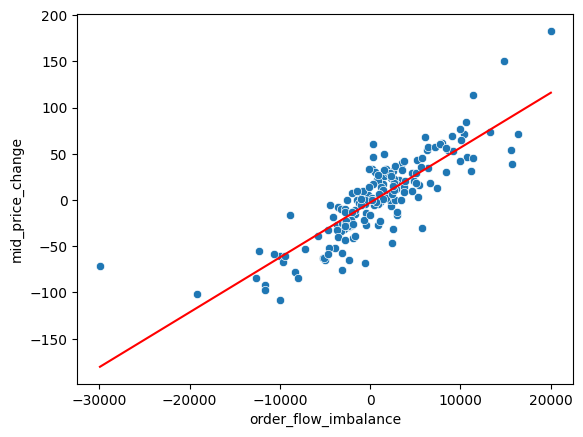

In [15]:
# | code-fold: true
np.random.seed(42)
instance = np.random.randint(0, 1313280 // 180)
with duckdb.connect(f"{data_dir}/{symbol}.db") as con:
    df = con.sql("SELECT * FROM agg_10s").to_df()
    df = df.iloc[instance * 180 : (instance + 1) * 180]
    model = smf.ols("mid_price_change ~ order_flow_imbalance", data=df)
    res = model.fit(cov_type="HAC", cov_kwds={"maxlags": int(180**0.25)})
    sns.scatterplot(data=df, x="order_flow_imbalance", y="mid_price_change")
    sns.lineplot(x=df.order_flow_imbalance, y=res.fittedvalues, color="red")

It does seem like there is a linear relationship between the two, for this interval at least. I'll now fit the model for all the 30 minute intervals for each of the three contracts.

In [16]:
class Results:
    def __init__(self):
        self.alphas = []
        self.betas = []
        self.alphas_p = []
        self.betas_p = []
        self.r2 = []

    def summarize(self):
        signif_alphas = np.sum(np.array(self.alphas_p) < 0.05) / len(self.alphas_p)
        signif_betas = np.sum(np.array(self.betas_p) < 0.05) / len(self.betas_p)
        avg_r2 = np.mean(self.r2)
        return pd.DataFrame(
            {
                "signif_alphas": [signif_alphas],
                "signif_betas": [signif_betas],
                "avg_r2": [avg_r2],
            }
        )


def global_summary(*results):
    dfs = [result.summarize() for result in results]
    concacted = pd.concat(dfs)
    return concacted.mean()


def estimate_regressions(symbol, data_dir, every=180):
    con = duckdb.connect(f"{data_dir}/{symbol}.db")
    query = f"""\
            SELECT * FROM agg_10s
            """
    df = con.execute(query).df()
    con.close()
    results = Results()
    for i in range(0, len(df), every):
        model = smf.ols(
            "mid_price_change ~ order_flow_imbalance", data=df.iloc[i : i + every]
        )
        res = model.fit(cov_type="HAC", cov_kwds={"maxlags": int(every**0.25)})
        results.alphas.append(res.params["Intercept"])
        results.betas.append(res.params["order_flow_imbalance"])
        results.alphas_p.append(res.pvalues["Intercept"])
        results.betas_p.append(res.pvalues["order_flow_imbalance"])
        results.r2.append(res.rsquared)
    return results


btc_results = estimate_regressions("BTCUSD_PERP", "./data/ticker")
eth_results = estimate_regressions("ETHUSD_PERP", "./data/ticker")
sol_results = estimate_regressions("SOLUSD_PERP", "./data/ticker")

In [17]:
btc_results.summarize()

,signif_alphas,signif_betas,avg_r2
0,0.204221,1.0,0.697402


In [18]:
eth_results.summarize()

,signif_alphas,signif_betas,avg_r2
0,0.310444,0.999863,0.706825


In [19]:
sol_results.summarize()

,signif_alphas,signif_betas,avg_r2
0,0.263569,0.992325,0.542729


In [20]:
global_summary(btc_results, eth_results, sol_results)

signif_alphas    0.259412
signif_betas     0.997396
avg_r2           0.648985
dtype: float64

In [21]:
from statsmodels.stats.multitest import multipletests

reject, _, _, _ = multipletests(
    np.array(sol_results.betas_p), alpha=0.05, method="fdr_bh"
)
np.average(reject)

np.float64(0.9923245614035088)

Overall, we have similar results as the paper. $\hat{\beta}$ is significant (when p-value is < .05) in >99% of the cases. The $R^2$ values average to around 65%. So a linear model of instantaneous price-impact does quite well. Let's try using 1 hour sized intervals instead of 30 minutes.


In [22]:
btc_results_hr = estimate_regressions("BTCUSD_PERP", "./data/ticker", every=360)
eth_results_hr = estimate_regressions("ETHUSD_PERP", "./data/ticker", every=360)
sol_results_hr = estimate_regressions("SOLUSD_PERP", "./data/ticker", every=360)

In [23]:
btc_results_hr.summarize()

,signif_alphas,signif_betas,avg_r2
0,0.238761,1.0,0.680708


In [24]:
eth_results_hr.summarize()

,signif_alphas,signif_betas,avg_r2
0,0.33909,1.0,0.690052


In [25]:
sol_results_hr.summarize()

,signif_alphas,signif_betas,avg_r2
0,0.26261,0.996436,0.520113


In [26]:
global_summary(btc_results_hr, eth_results_hr, sol_results_hr)

signif_alphas    0.280154
signif_betas     0.998812
avg_r2           0.630291
dtype: float64

We have similar findings for the hourly intervals too, indicating that the model could be robust over different time scales. I will not try different aggregations on the smaller time scale (e.g. 5s or 1s instead of 10s) as it just takes too long to run on my machine.

Is this model useful in a practical setting to make trades? Probably not. For one, it estimates the price impact over a time interval using data from that very same interval. The original paper proposes a way to use this method of analysis as a monitoring mechanism for adverse selection. I will not go into that here, but it could be of interest to explore in the future. Now, if we try to predict the change in the next interval, performance drops significantly. 

In [27]:
def estimate_regressions_fwd(symbol, data_dir, every=180):
    con = duckdb.connect(f"{data_dir}/{symbol}.db")
    query = f"""\
            SELECT * FROM agg_10s
            """
    df = con.execute(query).df()
    con.close()
    df["mid_price_change_next"] = df["mid_price_change"].shift(-1)
    results = Results()
    for i in range(0, len(df), every):
        model = smf.ols(
            "mid_price_change_next ~ order_flow_imbalance",
            data=df.iloc[i : i + every],
            missing="drop",
        )
        res = model.fit(cov_type="HAC", cov_kwds={"maxlags": int(every**0.25)})
        results.alphas.append(res.params["Intercept"])
        results.betas.append(res.params["order_flow_imbalance"])
        results.alphas_p.append(res.pvalues["Intercept"])
        results.betas_p.append(res.pvalues["order_flow_imbalance"])
        results.r2.append(res.rsquared)
    return results


btc_results_fwd = estimate_regressions_fwd("BTCUSD_PERP", "./data/ticker")
eth_results_fwd = estimate_regressions_fwd("ETHUSD_PERP", "./data/ticker")
sol_results_fwd = estimate_regressions_fwd("SOLUSD_PERP", "./data/ticker")
print(btc_results_fwd.summarize())
print(eth_results_fwd.summarize())
print(sol_results_fwd.summarize())

   signif_alphas  signif_betas    avg_r2
0       0.032895      0.412418  0.026467
   signif_alphas  signif_betas    avg_r2
0       0.035773      0.292626  0.017402
   signif_alphas  signif_betas    avg_r2
0       0.038377      0.124863  0.008959


Another concern is we are trying to estimate changes in price levels instead of returns, which means it must be estimated on a per asset basis. I'm curious if there's any generalization across the contracts. Going forward, I will try to implement a more practical model. 

# Can we use OFI as a signal?
To start, I want to have returns over the 10s intervals. I also want to do standardizations on the OFI. I will define returns as the change in the final midprice of one interval to the next. But everything done can be repeated for the bid/ask price as well. 

In [28]:
symbols = ["BTCUSD_PERP", "ETHUSD_PERP", "SOLUSD_PERP"]
data_dir = "./data/ticker"
for symbol in symbols:
    with duckdb.connect(f"{data_dir}/{symbol}.db") as con:
        con.execute(
            f"""
                    CREATE TABLE close_10s AS
                    WITH base_data AS (
                        SELECT 
                            transaction_time,
                            mid_price,
                            symbol,
                            date_trunc('year', MIN(transaction_time) OVER ()) AS min_time
                        FROM tick
                    )
                    SELECT
                        MAX_BY(mid_price, transaction_time) AS close_price,
                        symbol,
                        (min_time + INTERVAL '10 seconds' * (FLOOR(DATE_PART('epoch', transaction_time - min_time) / 10) + 1)::INT) AS time_bucket_end
                    FROM base_data
                    GROUP BY symbol, min_time + INTERVAL '10 seconds' * (FLOOR(DATE_PART('epoch', transaction_time - min_time) / 10) + 1)::INT
                    ORDER BY time_bucket_end
                    """
        )

In [ ]:
# | code-fold: true
symbols = ["BTCUSD_PERP", "ETHUSD_PERP", "SOLUSD_PERP"]
data_dir = "./data/ticker"
for symbol in symbols:
    with duckdb.connect(f"{data_dir}/{symbol}.db") as con:
        con.execute(
            f"""
                    CREATE TABLE open_10s AS
                    WITH base_data AS (
                        SELECT 
                            transaction_time,
                            mid_price,
                            symbol,
                            date_trunc('year', MIN(transaction_time) OVER ()) AS min_time
                        FROM tick
                    )
                    SELECT
                        MIN_BY(mid_price, transaction_time) AS open_price,
                        symbol,
                        (min_time + INTERVAL '10 seconds' * (FLOOR(DATE_PART('epoch', transaction_time - min_time) / 10) + 1)::INT) AS time_bucket_end
                    FROM base_data
                    GROUP BY symbol, min_time + INTERVAL '10 seconds' * (FLOOR(DATE_PART('epoch', transaction_time - min_time) / 10) + 1)::INT
                    ORDER BY time_bucket_end
                    """
        )

In [31]:
def collect_data():
    ofi_dfs = []
    close_dfs = []
    for symbol in symbols:
        with duckdb.connect(f"{data_dir}/{symbol}.db") as con:
            ofi_df = con.sql("SELECT * FROM agg_10s").to_df()
            close_df = con.sql("SELECT * FROM close_10s").to_df()
            ofi_dfs.append(ofi_df)
            close_dfs.append(close_df)
    return ofi_dfs, close_dfs


ofi_dfs, close_dfs = collect_data()

In [108]:
for df1, df2 in zip(ofi_dfs, close_dfs):
    df1["close_price"] = df2["close_price"]
    df1["returns"] = df2["close_price"].pct_change()
    del df2
del close_dfs

For standardization of OFI, I will use a rolling window of 1 minutes to compute z-scores. This is to account for the different levels of activity in the three contracts. I will then use the z-scores in the regression model.

In [74]:
for df in ofi_dfs:
    df["returns_next"] = df["returns"].shift(-1)
    df["ofi_rolling_mean"] = df["order_flow_imbalance"].rolling(6).mean()
    df["ofi_rolling_std"] = df["order_flow_imbalance"].rolling(6).std()
    df["ofi_z"] = (df["order_flow_imbalance"] - df["ofi_rolling_mean"]) / df[
        "ofi_rolling_std"
    ]

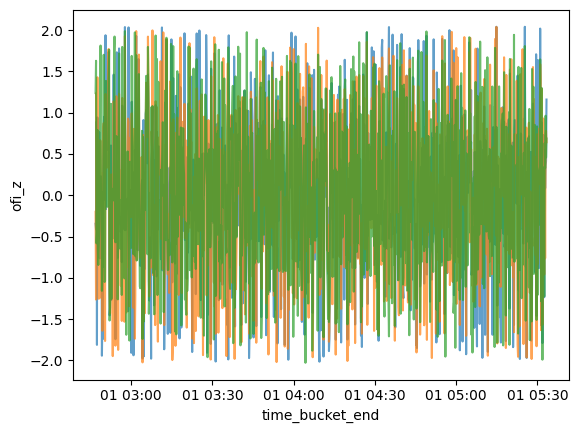

In [85]:
for df in ofi_dfs:
    sns.lineplot(data=df[1000:2000], x="time_bucket_end", y="ofi_z", alpha=0.7)

The standardization seems to put the OFI in the same range for all three contracts. A quick visualization for a thirty minute period doesn't show any obvious relationship between OFI and next 10s returns.

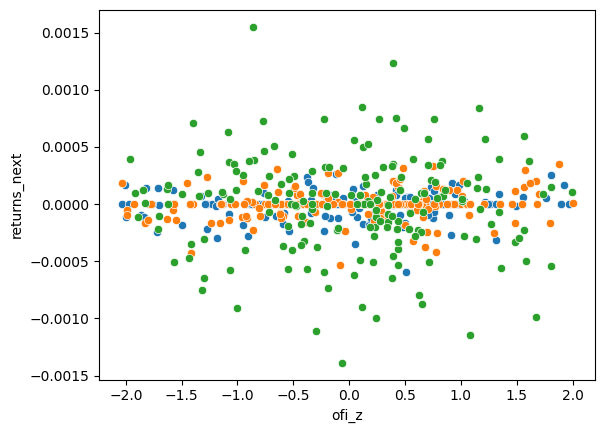

In [90]:
for df in ofi_dfs:
    sns.scatterplot(data=df.iloc[4000:4180], x="ofi_z", y="returns_next")

But I will repeat the procedure from above anyways.

In [94]:
class Results:
    def __init__(self):
        self.alphas = []
        self.betas = []
        self.alphas_p = []
        self.betas_p = []
        self.betas_t = []
        self.r2 = []

    def summarize(self):
        signif_alphas = np.sum(np.array(self.alphas_p) < 0.05) / len(self.alphas_p)
        signif_betas = np.sum(np.array(self.betas_p) < 0.05) / len(self.betas_p)
        avg_r2 = np.mean(self.r2)
        return pd.DataFrame(
            {
                "signif_alphas": [signif_alphas],
                "signif_betas": [signif_betas],
                "avg_t": [np.mean(self.betas_t)],
                "avg_r2": [avg_r2],
            }
        )


def global_summary(*results):
    dfs = [result.summarize() for result in results]
    concacted = pd.concat(dfs)
    return concacted.mean()


def estimate_regressions(df, every=180):
    results = Results()
    df = df.dropna()
    for i in range(0, len(df), every):
        model = smf.ols("returns_next ~ ofi_z", data=df.iloc[i : i + every])
        res = model.fit(cov_type="HAC", cov_kwds={"maxlags": int(every**0.25)})
        results.alphas.append(res.params["Intercept"])
        results.betas.append(res.params["ofi_z"])
        results.alphas_p.append(res.pvalues["Intercept"])
        results.betas_p.append(res.pvalues["ofi_z"])
        results.betas_t.append(res.tvalues["ofi_z"])
        results.r2.append(res.rsquared)
    return results


btc_results = estimate_regressions(ofi_dfs[0])
eth_results = estimate_regressions(ofi_dfs[1])
sol_results = estimate_regressions(ofi_dfs[2])

In [95]:
print(btc_results.summarize())
print(eth_results.summarize())
print(sol_results.summarize())

   signif_alphas  signif_betas    avg_t    avg_r2
0       0.040159       0.39693  1.64369  0.023374
   signif_alphas  signif_betas     avg_t    avg_r2
0       0.037144      0.294819  1.273421  0.016652
   signif_alphas  signif_betas     avg_t    avg_r2
0        0.03687      0.111431  0.472614  0.008378


It's about what we expect. Let's also run a regression over all the data with all the contracts pooled together.

In [101]:
def estimate_regressions_pooled(ofi_dfs):
    df = pd.concat(ofi_dfs)
    df = df.dropna()
    model = smf.ols("returns_next ~ ofi_z", data=df)
    res = model.fit(cov_type="HAC", cov_kwds={"maxlags": int(len(df) ** 0.25)})
    return res


pooled_results = estimate_regressions_pooled(ofi_dfs)
pooled_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           returns_next   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     6631.
Date:                Sat, 29 Jun 2024   Prob (F-statistic):               0.00
Time:                        23:31:47   Log-Likelihood:             2.4757e+07
No. Observations:             3939822   AIC:                        -4.951e+07
Df Residuals:                 3939820   BIC:                        -4.951e+07
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.952e-07   2.26e-07      2.187      0.029    5.14e-08    9.39e-07
ofi_z       2.202e-05    2.7e-07     81.431      0.000    2.15e-05    2.25e-05
==============================================================================
Omnibus:                  2017399.515   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      13986223540.388
Skew:                          -0.576   Prob(JB):                         0.00
Kurtosis:                     294.887   Cond. No.                         1.08
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 44 lags and without small sample correction
"""

We get a significant coefficient, but it's very bad at explaining the variance. So this normalized OFI does have useful information; it's a question of how to use it. Going back to the regressions for next 10s returns partitioned over the thirty minute intervals, perhaps a hypothesis to test is if the estimated $\hat{\beta}$ is significant in a thirty minute interval (by t-stat) then it will relatively do worse in the next thirty minute interval.

<Axes: xlabel='time'>

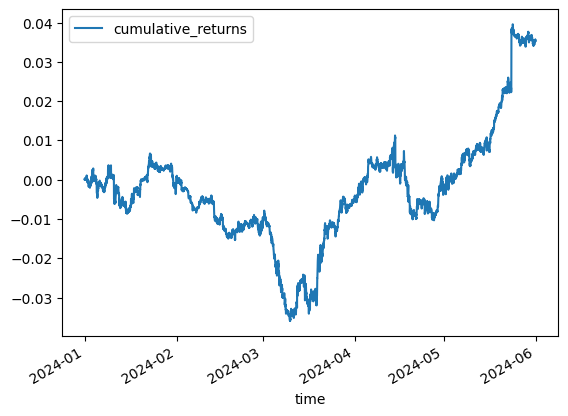

In [206]:
def get_times(every=180):
    df = ofi_dfs[0]
    times = []
    for i in range(0, len(df), every):
        times.append(df.iloc[i].time_bucket_end)
    return times


times = get_times()
assert len(times) == len(btc_results.betas_t)
assert len(times) == len(eth_results.betas_t)
assert len(times) == len(sol_results.betas_t)

btc_t_arr = np.array(btc_results.betas_t)

eth_t_arr = np.array(eth_results.betas_t)

sol_t_arr = np.array(sol_results.betas_t)

t_arr = np.column_stack((btc_t_arr, eth_t_arr, sol_t_arr))
signal = -t_arr / np.abs(t_arr).sum(axis=1)[:, None]
signal[np.isnan(signal)] = 0
signal = signal[:-1]

tradeable_times = [t + pd.Timedelta(seconds=20) for t in times[1:]]

returns_arr = np.column_stack(
    [df.loc[df.time_bucket_end.isin(tradeable_times)]["returns"] for df in ofi_dfs]
)

pd.DataFrame(
    {
        "cumulative_returns": (signal * returns_arr).sum(axis=1).cumsum(),
        "time": tradeable_times,
    }
).plot(x="time", y="cumulative_returns")

Well, that might just be noise. Maybe, life is simpler and we can use the OFI z-scores directly to weight a portfolio. The justification here is that the paper found that there is autocorrelation in OFI.

<Axes: xlabel='time'>

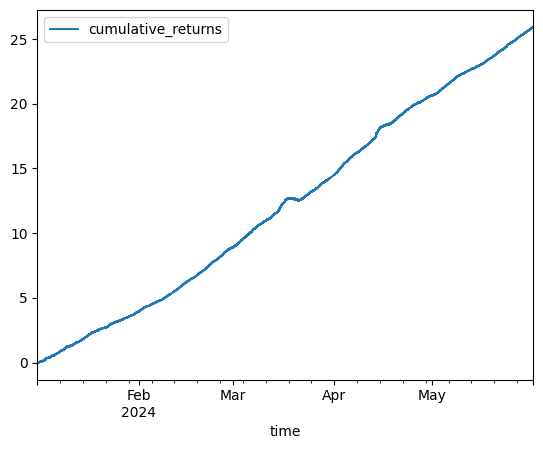

In [208]:
ofi_arr = np.column_stack([df.dropna()["ofi_z"] for df in ofi_dfs])
ret_next_arr = np.column_stack([df.dropna()["returns_next"] for df in ofi_dfs])
ofi_signal = ofi_arr / np.abs(ofi_arr).sum(axis=1)[:, None]

pd.DataFrame(
    {
        "cumulative_returns": (ofi_signal * ret_next_arr).sum(axis=1).cumsum(),
        "time": ofi_dfs[0].dropna()["time_bucket_end"],
    }
).plot(x="time", y="cumulative_returns")

Interesting, however this doesn't account for any trading costs, bid-ask spread, and so many other things. Perhaps something similar works on a longer time scale and across many more assets. I will end here for now, however.

# Conclusion
I guess the main takeaway is contemporaneous price change can be linearly modeled with OFI even for cryptocurrency perpetual contracts. This isn't anything new or surprising (e.g. [here](http://dspace.unive.it/bitstream/handle/10579/25649/893488-1286715.pdf?sequence=2) or [here](https://web.archive.org/web/20200325185331id_/https://link.springer.com/content/pdf/10.1007/s42521-019-00007-w.pdf)), but sometimes that's just how science works.

An avenue to explore could be thinking of Binance as the main reference for prices, then perhaps the OFI on Binance could be used to predict the price changes on other exchanges.